# Numerical exploration of the distribution moments for mRNA and protein.

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [ ]:
import glob
import pickle
import dill
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
import mpmath
import pandas as pd

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# figdir = '../../fig/chemical_master_analytic_protein/'
tmpdir = '../../tmp/'

### $\LaTeX$ macros
$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{foldchange}{\text{fold-change}}$

# Exploring the mRNA and protein distribution moments

Now that we have computed the mRNA and protein distribution moments for the two- and the three-state promoter let's numerically explore the analytical results.

## Import `lambdify` functions using `dill`.

When the analytical results were derived we generated `lambdify` functions to explore these results numerically and export them into a file using the `dill` library. Let's now import these functions into this notebook to make use of them.

In [2]:
# Import two-state mRNA moments
# Parameters are feed in the following order:
# (kp_on, kp_off, rm, gm)
with open(tmpdir + 'two_state_mRNA_lambdify.dill', 'rb') as file:
    first_unreg_m = dill.load(file)
    second_unreg_m = dill.load(file)
    third_unreg_m = dill.load(file)
    
# Import two-state mRNA moments
# Parameters are feed in the following order:
# (kr_on, kr_off, kp_on, kp_off, rm, gm)
with open(tmpdir + 'three_state_mRNA_lambdify.dill', 'rb') as file:
    first_reg_m = dill.load(file)
    second_reg_m = dill.load(file)
    third_reg_m = dill.load(file)

In [3]:
# Import two-state protein moments
# Parameters are feed in the following order:
# (kp_on, kp_off, rm, gm, rp, gp)
with open(tmpdir + 'two_state_protein_lambdify.dill', 'rb') as file:
    first_unreg_p = dill.load(file)
    second_unreg_p = dill.load(file)
    
# Import two-state protein moments
# Parameters are feed in the following order:
# (kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp)
with open(tmpdir + 'three_state_protein_lambdify.dill', 'rb') as file:
    first_reg_p = dill.load(file)
    second_reg_p = dill.load(file)

# Defining fano-factor and $\eta^2$ function.

Two interesting quantities is worth exploring is the fano-factor (variance / mean) and the noise-square function $\eta^2$ (variance / mean$^2$). Each of them have their experimental and theoretical advantages as discussed elsewhere.

Let's define a function that computes these quantities.

In [4]:
def fano_unreg_m(kp_on, kp_off, rm, gm):
    '''
    Computes the fano-factor (variance / mean) for a two-state unregulated promoter
    at the mRNA level
    Parameters
    ----------
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    Returns
    -------
    mRNA fano-factor for an unregulated promoter.
    '''
    return (second_unreg_m(kp_on, kp_off, rm, gm) -\
            first_unreg_m(kp_on, kp_off, rm, gm)**2) /\
            first_unreg_m(kp_on, kp_off, rm, gm)

In [5]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=0.017, kp_off=0.132, rm=0.354, gm=0.00284)

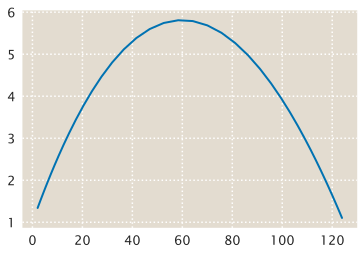

In [6]:
kp_off_array = np.logspace(-4,0)
par = par_UV5.copy()
par['kp_off'] = kp_off_array

plt.plot(first_unreg_m(*par.values()), fano_unreg_m(**par))

# Two-state promoter homogeneity in time at mRNA level

As described by Peccoud & Ycart the model at the mRNA level is homogeneous in time. What that means is that multiplying the time scale by a constant is equivalent to dividing all rates by the same constant. That is why when determining the parameters we can at best get the rates $\kpon$, $\kpoff$ and $\rm$ in units of the degradation rate $\gm$.

In order to confirm that let's plot the fano-factor for different values of $\gm$ while maintaining the relative values of the other rates. If the model is indeed homogeneous in time we expect the fano-factor to remain constant as we vary the absolute value of $\gm$ while maintaining the relative values of the other rates.

(2, 4)

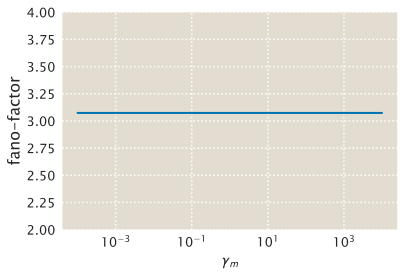

In [7]:
# List the parameter values in units of the degradation rate gm
par_UV5 = dict(kp_on=5.858, kp_off=46.554, rm=124.706, gm=1)
# Define array of gm values to explore
gm_array = np.logspace(-4, 4)

# Copy parameters dictionary
par = par_UV5.copy()

# Initialize array to save fano factor values
fano_var_gm = np.empty_like(gm_array)
# Loop through gm values
for i, gm in enumerate(gm_array):
    # Update parameters
    par['gm'] = gm
    par['kp_on'] = par_UV5['kp_on'] * gm
    par['kp_off'] = par_UV5['kp_off'] * gm
    par['rm'] = par_UV5['rm'] * gm
    # Compute and save noise
    fano_var_gm[i] = fano_unreg_m(**par)

plt.plot(gm_array, fano_var_gm)
plt.xlabel(r'$\gamma_m$')
plt.ylabel(r'fano-factor')
plt.xscale('log')
plt.ylim([2, 4])

This plot shows that at the mRNA level the unregulated promoter is indeed homogeneous in time.

# Compare two-state promoter protein noise with Shahrezaei & Swain

Shahrezaei & Swain in their 2008 paper derived an expression for the noise in protein copy numbers of the form
\begin{equation}
\eta^2 = \frac{1}{\langle p \rangle} + \frac{\gp}{\gm} \frac{1}{\langle m \rangle} + \frac{\gp}{\gp + \kpon + \kpoff} \frac{\kpoff}{\kpon}.
\end{equation}

This is derived under the assumption that $\gm \gg \gp$. Let's compare this with the complete analytical result as obtained by computing the moments directly from the master equation.

Let's define both functions to compute the S & S approximation and the full form of the noise.

In [8]:
def noise_square_unreg_swain(kp_on, kp_off, rm, gm, rp, gp):
    '''
    Computes the noise square (variance / mean**2) for a two-state unregulated 
    promoter at the protein level as derived by Shahrezaei & Swain PNAS 2008. 
    This approximation is valid for gm >> gp.
    Parameters
    ----------
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    rp : float.
        translation initiation rate. [time**-1]
    gp : float.
        protein degradation rate. [time**-1]
    Returns
    -------
    protein noise for an unregulated promoter.
    '''
    # Compute the mean mRNA
    mean_m = (rm / gm) * kp_on / (kp_on + kp_off)
    # Compute the mean protein
    mean_p = (rp / gp) * mean_m
    
    return 1 / mean_p + (gp / gm) * (1 / mean_m) +\
           gp / (gp + kp_on + kp_off) * (kp_off / kp_on)

In [9]:
def noise_square_unreg_p(kp_on, kp_off, rm, gm, rp, gp):
    '''
    Computes the noise square (variance / mean**2) for a two-state unregulated 
    promoter at the protein level.
    Parameters
    ----------
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    rp : float.
        translation initiation rate. [time**-1]
    gp : float.
        protein degradation rate. [time**-1]
    Returns
    -------
    protein noise square for an unregulated promoter.
    '''
    return second_unreg_p(kp_on, kp_off, rm, gm, rp, gp) /\
           first_unreg_p(kp_on, kp_off, rm, gm, rp, gp)**2 - 1

Having defined the functions let's compare them for different values of $\gp$ using the most likely parameters for the *lacUV5* promoter.

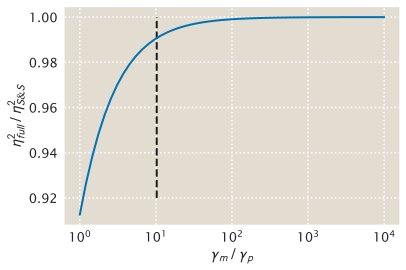

In [10]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=0.017, kp_off=0.132, rm=0.354, gm=0.00284,
               gp=0.000277)
# define rp based on the mean protein copy number per mRNA
par_UV5['rp'] = 1000 * par_UV5['gp']

# Define a range of gm / gp ratios
gamma = np.logspace(0, 4) # gm / gp

# Copy the UV5 parameters and modify gp
par = par_UV5.copy()
par['gp'] = par['gp'] / gamma

# Plot the ratio of noises
plt.plot(gamma, noise_square_unreg_p(**par) / noise_square_unreg_swain(**par))
# Indicate with vertical line the most likely value of the gm / gp ratio
plt.vlines(par_UV5['gm'] / par_UV5['gp'], 0.92, 1, linestyle='--')
# Label plot
plt.xscale('log')
plt.xlabel(r'$\gamma_m \; / \; \gamma_p$')
_ = plt.ylabel(r'$\eta^2_{full} \; / \; \eta^2_{S&S}$')

From this plot we can see that Shahrezaei & Swain's approximation works the best as the assumption of $\gm \gg \gp$ is better satisfied. From the vertical line we can see that for our assumption the approximation is already very accurate.

# Two-state promoter homogeneity in time at protein level

Just as with the mRNA level we will verify if the two-state model is homogeneous in time. First lets vary the absolute value of the protein degradation rate $\gm$ adjusting all other rates relative values to this.

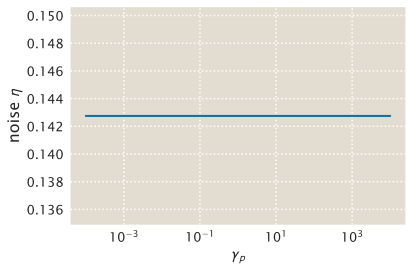

In [24]:
# List the parameter values in units of the degradation rate gm
par_UV5 = dict(kp_on=5.858, kp_off=46.554, rm=124.706, gp=1)

# Define array of gp values to explore
gp_array = np.logspace(-4, 4)

# Copy parameters dictionary
par = par_UV5.copy()

# Initialize array to save fano factor values
noise_square_var_gp = np.empty_like(gp_array)
# Loop through gp values
for i, gp in enumerate(gp_array):
    # Update parameters
    par['gp'] = gp
    par['gm'] = gp * 10
    par['kp_on'] = par_UV5['kp_on'] * par['gm']
    par['kp_off'] = par_UV5['kp_off'] * par['gm']
    par['rm'] = par_UV5['rm'] * par['gm']
    par['rp'] = 1000 * gp # if rp/gp is the average number of protein/mRNA
    # Compute and save noise
    noise_square_var_gp[i] = noise_square_unreg_p(**par)

plt.plot(gp_array, np.sqrt(noise_square_var_gp).round(5))
plt.xlabel(r'$\gamma_p$')
plt.ylabel(r'noise $\eta$')
plt.xscale('log')

Again this plot shows that the noise is also homogeneous in time at the protein level. Just to make sure that it is not something specific of the noise let's repeat this plot for the first and second moment by themselves.

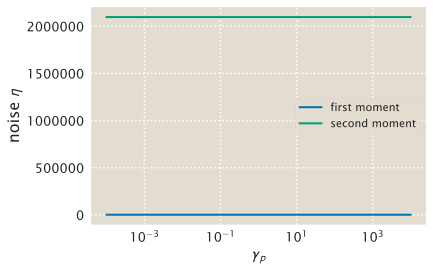

In [28]:
# List the parameter values in units of the degradation rate gm
par_UV5 = dict(kp_on=5.858, kp_off=46.554, rm=124.706, gp=1)

# Define array of gp values to explore
gp_array = np.logspace(-4, 4)

# Copy parameters dictionary
par = par_UV5.copy()

# Initialize array to save fano factor values
first_var_gp = np.empty_like(gp_array)
second_var_gp = np.empty_like(gp_array)
# Loop through gp values
for i, gp in enumerate(gp_array):
    # Update parameters
    gm = gp * 10
    kp_on = par_UV5['kp_on'] * gm
    kp_off = par_UV5['kp_off'] * gm
    rm = par_UV5['rm'] * gp
    rp = 1000 * gp # if rp/gp is the average number of protein/mRNA
    # Compute and save noise
    first_var_gp[i] = first_unreg_p(kp_on, kp_off, rm, gm, rp, gp)
    second_var_gp[i] = second_unreg_p(kp_on, kp_off, rm, gm, rp, gp)

plt.plot(gp_array, first_var_gp.round(5), label='first moment')
plt.plot(gp_array, second_var_gp.round(5), label='second moment')
plt.xlabel(r'$\gamma_p$')
plt.ylabel(r'noise $\eta$')
plt.xscale('log')
plt.legend()

An interesting question is now how much the ratio $\gm / \gp$ affects this noise. Let's plot the noise as we scale this ratio. 

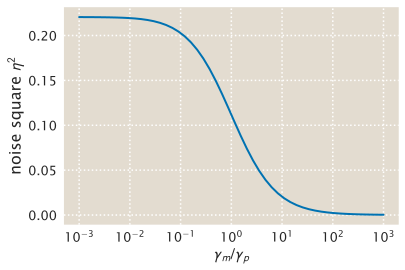

In [47]:
# List the parameter values in units of the degradation rate gm
par_UV5 = dict(kp_on=5.858, kp_off=46.554, rm=124.706, gp=1)

# Define array of gp values to explore
gamma_array = np.logspace(-3, 3)

# Copy parameters dictionary
par = par_UV5.copy()

# Initialize array to save fano factor values
noise_square_var_gamma = np.empty_like(gp_array)
# Loop through gp values
for i, gamma in enumerate(gamma_array):
    # Update parameters
    par['gm'] = par_UV5['gp'] * gamma
    par['kp_on'] = par_UV5['kp_on'] * par['gm']
    par['kp_off'] = par_UV5['kp_off'] * par['gm']
    par['rm'] = par_UV5['rm'] * par['gm']
    par['rp'] = 1000 * par_UV5['gp'] # rp/gp is the average number of protein/mRNA
    # Compute and save noise
    noise_square_var_gamma[i] = noise_square_unreg_p(**par)

plt.plot(gamma_array, noise_square_var_gamma)
plt.xlabel(r'$\gamma_m / \gamma_p$')
plt.ylabel(r'noise square $\eta^2$')
plt.xscale('log')
# plt.ylim([59.5, 60.5])

This ratio of degradation rates does have an effect in the noise at the protein level.

Since we do not know with certainty the value of these degradation rates, let's try to obtain a good estimate for this ratio given our experimental data.

# Estimating the $\gm / \gp$ ratio from experimental data.

Given the data that we have on unregulated promoters we can try to estimate the ratio of the degradation rates $\gm / \gp$. For this we will import the single-cell microscopy data for the $\Delta$*lacI* strains and compute the noise $\eta$.

In [29]:
files = glob.glob('../../data/csv_microscopy/*csv')# + mwc_files
df_micro = pd.concat(pd.read_csv(f, comment='#') for f in files if 'Oid' not in f)
df_micro[['date', 'operator', 'rbs', 'mean_intensity']].head()

,date,operator,rbs,mean_intensity
0,20161204,O3,auto,52.562979
1,20161204,O3,auto,53.070565
2,20161204,O3,auto,52.323744
3,20161204,O3,auto,51.013142
4,20161204,O3,auto,44.325267


Let's now compute the noise square $\eta^2$

In [43]:
# group by date and by IPTG concentration
df_group = df_micro.groupby(['date'])

# Initialize data frame to save the noise
df_delta_noise = pd.DataFrame(columns=['date', 'operator', 'binding_energy',
                                      'mean_intensity', 'variance', 'noise_square'])
for date, data in df_group:
    # Extract the mean autofluorescence
    I_auto = data[data.rbs == 'auto'].mean_intensity.mean()
    
    # Extract the strain fluorescence measurements
    delta_data = data[data.rbs == 'delta']
    
    # Append the require info
    delta_info = [date, delta_data.operator.unique()[0],
                   delta_data.binding_energy.unique()[0],
                  (delta_data.mean_intensity - I_auto).mean(), 
                  (delta_data.mean_intensity - I_auto).var(ddof=1)]
    # Compute the noise
    delta_info.append(delta_info[-1] / delta_info[-2]**2)
    # Convert to a pandas series to attach to the dataframe
    delta_info = pd.Series(delta_info, index=['date', 'operator', 
                                                'binding_energy', 'mean_intensity',
                                                'variance', 'noise_square'])
    # Append to the info to the data frame
    df_delta_noise = df_delta_noise.append(delta_info, ignore_index=True)
    
df_delta_noise

,date,operator,binding_energy,mean_intensity,variance,noise_square
0,20161118,O2,-13.9,2300.650565,7.883521e+05,0.148943
1,20161129,O2,-13.9,2402.292147,2.220527e+06,0.384773
2,20161203,O2,-13.9,4772.751592,2.445088e+06,0.107339
3,20161204,O3,-9.7,5426.807369,4.364849e+06,0.148211
4,20161205,O3,-9.7,3495.582203,2.072394e+06,0.169603
5,20161207,O2,-13.9,2592.440501,1.530774e+06,0.227768


Let's now define a function that computes the residuals between the theoretical and the experimental value in order to find the ratio of degradation rates that better fits the available data.

In [64]:
def resid(gamma, noise_square_exp, unreg_par):
    '''
    Computes the residuals of the theoretical and the experimental noise-square
    for a two-state unregulated promoter
    '''
    par = unreg_par.copy()
    
    # Update parameters
    par['gm'] = unreg_par['gp'] * gamma
    par['kp_on'] = unreg_par['kp_on'] * par['gm']
    par['kp_off'] = unreg_par['kp_off'] * par['gm']
    par['rm'] = unreg_par['rm'] * par['gm']
    par['rp'] = 1000 * unreg_par['gp']
    # Compute and save noise
    return  noise_square_exp - noise_square_unreg_p(**par)

In [65]:
# List the parameter values in units of the degradation rate gm
par_UV5 = dict(kp_on=5.858, kp_off=46.554, rm=124.706, gm=1, gp=1)

# Initial guess for the gm / gp ratio
p0 = 100

popt = scipy.optimize.least_squares(resid, p0, 
       args=(df_delta_noise.noise_square.values, par_UV5))
popt.x

<string>:1: RuntimeWarning: invalid value encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide


array([ 0.12798717])

This number that we are obtaining does not make sense. We know that the protein has a much longer life-time than mRNA so we expected the ratio of degradation rates to be much larger than 1.

If we were to consider that this ratio $\gm / \gp$ is of order 10, then assumed that the microscopy reading added a constant noise such that these measurements were of the form
$$
\eta_{\text{data}}^2 = \eta_{\text{measurement}}^2 +
                       \eta_{\text{gene expression}}^2,
$$
where $\eta_{\text{measurement}}^2$ is the constant noise added by the microscope and $\eta_{\text{gene expression}}^2$ is the intrinsic noise given by the physics of gene expression, we could have that $\eta_{\text{measurement}}^2$ from this data.

In [74]:
# List the parameter values in units of the degradation rate gm
par_UV5 = dict(kp_on=5.858, kp_off=46.554, rm=124.706, gm=1, gp=1)

# Copy the parameters
par = par_UV5.copy()
# Define the ratio gm / gp
gamma = 10
    
# Update parameters
par['gm'] = par_UV5['gp'] * gamma
par['kp_on'] = par_UV5['kp_on'] * par['gm']
par['kp_off'] = par_UV5['kp_off'] * par['gm']
par['rm'] = par_UV5['rm'] * par['gm']
par['rp'] = 1000 * par_UV5['gp']

df_delta_noise.noise_square.mean() -  noise_square_unreg_p(**par)

0.17739493011876925

# Explore the noise for the regulated three-state promoter.

Let's now explore how the noise scales as the repressor copy number. The way that the repressor copy number enters the kinetic scheme is by assuming that the $\kron$ rate is a diffusion limited rate of the form
$$
\kron = k_o \left[ R \right].
$$
The constant $k_o$ was indirectly inferred by the Sunney Xie lab and quoted by Jones and Brewster as $k_o = 2.7 \times 10^{-3} (\text{s nM})^{-1}$.

The value of $\kroff$ is then constrained by the value of the binding energy as inferred using equilibrium statistical mechanics. For the stat. mech. framework we have that the fold-change in gene expression is given by
$$
\foldchange = \frac{1}{1 + \frac{R \cdot p_{act}}{N_{NS}} e^{-\beta \Delta \epsilon_r}},
$$
where $R$ is the absolute copy number of repressors per cell, $N_{NS}$ is the number of non-specific binding sites for the repressors (in our case the entire *E. coli genome* $4.6 \times 10^6$), $\beta$ is the inverse temperature times the Boltzmann constant and $\Delta \epsilon_r$ is the binding energy of the repressor to the operator binding site.

In the case of the three-state promoter the fold-change is given by
$$
\foldchange = {1 \over 1 + {\kron \over \kroff} 
               \left( {\kpoff \over \kpoff + \kpon} \right)}
            = {1 \over 1 + {k_o [R] p_{act} \over \kroff} 
               \left( {\kpoff \over \kpoff + \kpon} \right)}.
$$

Given that these two equation have the same functional form we can conclude that
$$
\frac{R \cdot p_{act}}{N_{NS}} e^{-\beta \Delta \epsilon_r} =
{k_o [R] p_{act} \over \kroff} 
               \left( {\kpoff \over \kpoff + \kpon} \right).
$$
If we solve for $\kroff$ and convert the absolute number or repressors $R$ into a concentration $[R]$ we find that
$$
\kroff = 1.66 \cdot k_0 \cdot N_{NS} e^{\beta \Delta \epsilon_r}
          \left( {\kpoff \over \kpoff + \kpon} \right).
$$

Given this result let's define a function that computes $\kroff$ as a function of the binding energies and the RNAP rates.

In [75]:
def kr_off_fun(eRA, k0=2.7E-3, kp_on=0.017, kp_off=0.132, Nns=4.6E6):
    '''
    Returns the off rate of the repressor as a function of the stat. mech. binding
    energy and the RNAP on and off rates
    Parameters
    ----------
    eRA : float.
        Repressor binding energies [kbT]
    k0 : float.
        Diffusion limited constant [s**-1 nM**-1]
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    Nns : float.
        Number of non-specific binding sites
    Returns
    -------
    Repressor off rate
    '''
    return 1.66 * k0 * Nns * np.exp(eRA) * kp_off / (kp_off + kp_on)

Let's now define a function that computes the noise square $\eta^2$ for the regulated promoter as a function of repressor copy number and inducer concentration. For this we will assume that the number of active repressors is given by the equilibrium value as determiend by $R_{act} = R \cdot p_{act}$, where $p_{act}$ is given by the MWC model.

In [94]:
def noise_square_reg_p(C, rep, eRA, rm, gm, rp, gp,
                k0=2.7E-3, kp_on=0.017, kp_off=0.132, Nns=4.6E6,
                ka=139, ki=0.53, epsilon=4.5):
    '''
    Computes the noise square in protein copy number (variance / mean**2)
    as a function  of all the parameters that go into the chemical master 
    equation.
    
    Parameters
    ----------
    C : array-like.
        Concentration at which evaluate the probability.
    rep: float.
        repressor copy number per cell.
    eRA : float.
        Repressor binding energy [kBT]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    rp : float.
        translation initiation rate. [time**-1]
    gp : float.
        protein degradation rate. [time**-1]
    k0 : float.
        diffusion limited rate of a repressor binding the promoter
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    Nns : float.
        Number of non-specific binding sites
    ki, ka : float.
        dissociation constants for the inactive and active states respectively
        in the MWC model of the lac repressor.
    epsilon : float.
        energetic barrier between the inactive and the active state.
        
    Returns
    -------
    eta the noise in protein distribution
    '''
    # Convert C into np.array
    C = np.array(C)
    
    # Calculate the repressor on rate including the MWC model
    kr_on = k0 * rep * chann_cap.p_act(C, ka, ki, epsilon)
    # Compute the repressor off-rate based on the on-rate and the binding energy
    kr_off = kr_off_fun(eRA, k0, kp_on, kp_off, Nns)
    
    return second_reg_p(kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp) /\
           first_reg_p(kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp)**2 - 1

### Noise for varying repressor copy number

Now that we have this function let's compute the noise for varying number of repressors at fix binding energy.

Text(0.5,1,'operator O1')

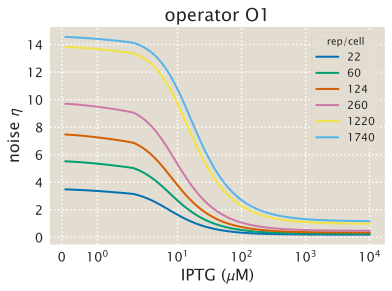

In [95]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.858, kp_off=46.554, rm=124.706,
               gm=1, gp=1, k0=2.7E-3)

# Define the IPTG concentrations to evaluate the theoretical noise
IPTG = np.logspace(-1, 4, 100)

# Define the repressor copy numbers to use
repressors = [22, 60, 124, 260, 1220, 1740]
# Define the binding energy
eRA = -15.3

# Copy parameter set and update it according to the gm/gp ratio
par = par_UV5.copy()
gamma = 10
# Update parameters
par['gm'] = par_UV5['gp'] * gamma
par['kp_on'] = par_UV5['kp_on'] * par['gm']
par['kp_off'] = par_UV5['kp_off'] * par['gm']
par['rm'] = par_UV5['rm'] * par['gm']
par['rp'] = 1000 * par_UV5['gp']
par['eRA'] = eRA

for rep in repressors:
    par['rep'] = rep
    noise_square = noise_square_reg_p(IPTG, **par)
    plt.plot(IPTG, np.sqrt(noise_square), label='{:d}'.format(rep))

plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.legend(title='rep/cell')
plt.title('operator O1')


### Noise for varying binding energy

Let's now compute the noise for varying binding energy at fix repressor copy number

Text(0.5,1,'$R = 260$ rep/cell')

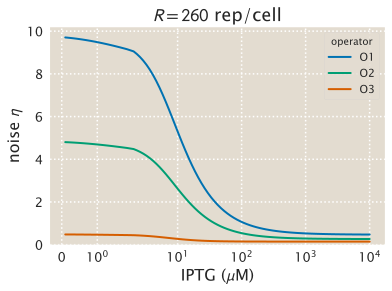

In [96]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.858, kp_off=46.554, rm=124.706,
               gm=1, gp=1, k0=2.7E-3)

# Define the IPTG concentrations to evaluate the theoretical noise
IPTG = np.logspace(-1, 4, 100)
# Define the repressor copy numbers to use
energies = dict(zip(['O1', 'O2', 'O3'], [-15.3, -13.9, -9.7]))

# Copy parameter set and update it according to the gm/gp ratio
par = par_UV5.copy()
gamma = 10
# Update parameters
par['gm'] = par_UV5['gp'] * gamma
par['kp_on'] = par_UV5['kp_on'] * par['gm']
par['kp_off'] = par_UV5['kp_off'] * par['gm']
par['rm'] = par_UV5['rm'] * par['gm']
par['rp'] = 1000 * par_UV5['gp']
par['rep'] = 260

for energy, eRA in energies.items():
    par['eRA'] = eRA
    noise_square = noise_square_reg_p(IPTG, **par)
    plt.plot(IPTG, np.sqrt(noise_square), label='{:s}'.format(energy))

plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.ylim(bottom=0)
plt.legend(title='operator')
plt.title(r'$R = 260$ rep/cell')


# Testing three-state model with experimental data.

In [81]:
# Read the tidy-data frame
files = glob.glob('../../data/csv_microscopy/*csv')# + mwc_files
df_micro = pd.concat(pd.read_csv(f, comment='#') for f in files if 'Oid' not in f)
df_micro[['date', 'operator', 'rbs', 'mean_intensity']].head()

,date,operator,rbs,mean_intensity
0,20161204,O3,auto,52.562979
1,20161204,O3,auto,53.070565
2,20161204,O3,auto,52.323744
3,20161204,O3,auto,51.013142
4,20161204,O3,auto,44.325267


In [84]:
# group by date and by IPTG concentration
df_group = df_micro.groupby(['date'])

# Initialize data frame to save the noise
var = ['date', 'IPTG_uM','operator', 'binding_energy', 'rbs', 'repressors', 
       'mean', 'std', 'noise_square']
df_noise = pd.DataFrame(columns=var)
for date, data in df_group:
    # Extract the mean autofluorescence
    I_auto = data[data.rbs == 'auto'].mean_intensity.mean()
    
    # Extract the strain fluorescence measurements
    strain_data = data[(data.rbs != 'auto') & (data.rbs != 'delta')]
    
    # Group data by IPTG measurement
    data_group = strain_data.groupby('IPTG_uM')
    for inducer, data_inducer in data_group:
        # Append the require info
        strain_info = [date, inducer, data_inducer.operator.unique()[0],
                       data_inducer.binding_energy.unique()[0],
                       data_inducer.rbs.unique()[0],
                       data_inducer.repressors.unique()[0],
                      (data_inducer.mean_intensity - I_auto).mean(), 
                      (data_inducer.mean_intensity - I_auto).var(ddof=1)]
        # Compute the noise
        strain_info.append(strain_info[-1] / strain_info[-2]**2)
        # Convert to a pandas series to attach to the dataframe
        strain_info = pd.Series(strain_info, index=var)
        # Append to the info to the data frame
        df_noise = df_noise.append(strain_info, ignore_index=True)
    
df_noise.head()

,date,IPTG_uM,operator,binding_energy,rbs,repressors,mean,std,noise_square
0,20161118,0.0,O2,-13.9,RBS1027,130,28.660991,1175.976490,1.431582
1,20161118,0.1,O2,-13.9,RBS1027,130,29.234495,1210.486104,1.416344
2,20161118,5.0,O2,-13.9,RBS1027,130,71.514148,2829.580422,0.553271
3,20161118,10.0,O2,-13.9,RBS1027,130,129.849144,7627.019220,0.452352
4,20161118,25.0,O2,-13.9,RBS1027,130,391.288683,57668.980651,0.376658


(-0.5, 8402.7716270925066)

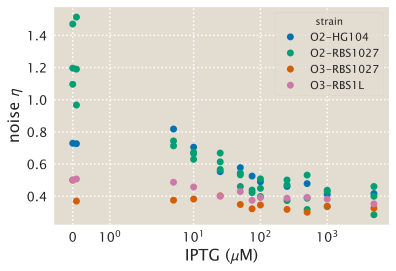

In [86]:
df_group = df_noise.groupby(['operator', 'rbs'])
    
for group, data in df_group:
    plt.plot(data.IPTG_uM, np.sqrt(data.noise_square), lw=0, marker='o',
            label='{0:s}-{1:s}'.format(group[0], group[1]))
plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.legend(title='strain')
plt.xlim(left=-5E-1)

In [118]:
def resid(k0, gamma, df, reg_par, correction=.177):
    '''
    Computes the residuals of the theoretical and the experimental noise-square
    for a two-state unregulated promoter
    '''
    par = reg_par.copy()
    # Update parameters
    par['gm'] = reg_par['gp'] * gamma
    par['kp_on'] = reg_par['kp_on'] * par['gm']
    par['kp_off'] = reg_par['kp_off'] * par['gm']
    par['rm'] = reg_par['rm'] * par['gm']
    par['rp'] = 1000 * reg_par['gp']
    par['k0'] = k0 * par['gp']
    
    # Group by date and concentration
    noise_group = df.groupby(['date','IPTG_uM'])
    
    residuals = []
    # Loop through groups returning the residuals
    for group, data in noise_group:
        # Specify parameters for specific data set
        binding_energy = data.binding_energy.unique()[0]
        repressors = data.repressors.unique()[0]
        par['rep'] = 2 * 1.66 * repressors
        par['eRA'] = binding_energy
        par['C'] = group[1]
        # Compute experimental noise
        avg_noise = data.noise_square.values - correction
        # Append linear residuals
        residuals.append(noise_square_reg_p(**par) - avg_noise)
    
    return np.array(residuals).ravel()

In [128]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.858, kp_off=46.554, rm=124.706,
               gm=1, gp=1)

gamma = 10
# Initial guess for the k0 value
p0 = 1
df = df_noise[(df_noise.operator == 'O2') & (df_noise.rbs == 'RBS1027')]
popt = scipy.optimize.least_squares(resid, p0, 
       args=(gamma, df, par_UV5, .177))
popt.x

array([ 4437.33294678])

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt


(-0.5, 17398.189457156805)

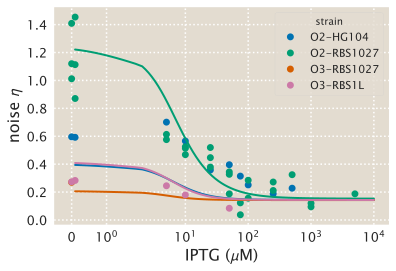

In [133]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.858, kp_off=46.554, rm=124.706,
               gm=1, gp=1)
# Copy parameter set and update it according to the gm/gp ratio
par = par_UV5.copy()
gamma = 10
k0 = 10
# Update parameters
par['gm'] = par_UV5['gp'] * gamma
par['kp_on'] = par_UV5['kp_on'] * par['gm']
par['kp_off'] = par_UV5['kp_off'] * par['gm']
par['rm'] = par_UV5['rm'] * par['gm']
par['rp'] = 1000 * par_UV5['gp']
par['k0'] = k0 * par['gp']

# Group by operator and rbs
df_group = df_noise.groupby(['operator', 'rbs'])

colors = sns.color_palette('colorblind', n_colors=len(df_group))

i = 0
for group, data in df_group:
    # Extract energy and number of repressors
    par['eRA'] = data.binding_energy.unique()[0]
    # Indicate the repressor copy number
    par['rep'] = data.repressors.unique()[0] * 1.66 * 2
    
    # Compute the theoretical noise for different IPTG concentrations
    noise_thry = np.sqrt(noise_square_reg_p(IPTG, **par))
    # Plot the theoretical noise
    plt.plot(IPTG, noise_thry, color=colors[i])
    # Polot the experimental noise
    plt.plot(data.IPTG_uM, np.sqrt(data.noise_square.values - .177), 
             lw=0, marker='o', label='{0:s}-{1:s}'.format(group[0], group[1]),
             color=colors[i])
    i+=1
plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.legend(title='strain')
plt.xlim(left=-5E-1)
# plt.ylim(bottom=0)